# Carga de datos

Lo primero que hago es cargar los datos de la página web indicada en el enunciado. Dentro de esta página web, existe un dataset para las distintas categorías en que se divide los productos de Amazon (Books, Electronics, Movies and TV...) Cada dataset recoge las valoraciones producidas por usuarios para productos pertenecientes a cada categoría. Como consecuencia, existen categorías que poseen más valoraciones que otras. Por ejemplo la categoría de libros posee 8000000 millones de valoraciones aproximadamente mientras que la categoría Automotive posee solamente 20473 valoraciones. Por ello, lo primero es decidir cual es el dataset que voy a utilizar.

En mi caso voy a utilizar en esta práctica el dataset de Películas y TV por dos motivos. El primero porque posee un buen número de valoraciones (concretamente 16891888 valoraciones) por lo que dado que voy a entrenar un modelo NPL con técnicas de DeepLearning, creo que es mejor tener el mayor número posible de valoraciones. (Es cierto que existen otros dos datasets con más valoraciones pero considero que con un millón y medio de valoraciones es suficiente). Por otro lado, el segundo motivo por el que elijo esta categoría es porque me gustan las películas y TV y creo que puede ser interesante conocer un poco la materia con la que se va a trabajar ya que esto puede ayudar en un futuro a tomar decisiones.

Por lo tanto, utilizando la función !wget descargo el fichero comprimido y lo descomprimo con la función !gunzip.

In [ ]:
# Descarga el archivo JSON comprimido
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz

# Descomprime el archivo JSON comprimido
!gunzip reviews_Movies_and_TV_5.json.gz


--2024-05-02 17:39:12--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708988936 (676M) [application/x-gzip]
Saving to: ‘reviews_Movies_and_TV_5.json.gz’

reviews_Movies_and_ 100%[===================>] 676.14M  17.6MB/s    in 52s     

2024-05-02 17:40:04 (13.1 MB/s) - ‘reviews_Movies_and_TV_5.json.gz’ saved [708988936/708988936]



Descargado el fichero, voy a crear un diccionario con todas las valoraciones. De primeras he intentado realizlo con la función json.load pero existen valoraciones que están mal formateadas, por lo que no es posible hacerlo todo de golpe. Es por eso que utilizo try y except para que en caso de que una valoración este mal formateada, no la incluya en el diccionario.

In [ ]:
import json

ruta_archivo = "reviews_Movies_and_TV_5.json"
reviews_dict = {}

with open(ruta_archivo, "r") as archivo:
    for linea in archivo:
        try:
            # Analizo la línea como un objeto JSON, obtiene su identidicador único y almacena la reseña utilizando el identificador
            review = json.loads(linea)
            review_id = review['reviewerID']
            reviews_dict[review_id] = review
        except json.JSONDecodeError:
            # Si hay un error al analizar la línea como JSON, la omite
            continue



Para comprobar que se ha cargado todo correctamente, observo cinco valoraciones aleatorias.

In [ ]:
import random

# Obtengo una lista de cinco claves aleatorias del diccionario
claves_aleatorias = random.sample(reviews_dict.keys(), 5)
print(claves_aleatorias)

# Imprimo los elementos correspondientes a las claves aleatorias seleccionadas
for clave in claves_aleatorias:
    print(reviews_dict[clave])


['ABNLTWYTCY7MF', 'A1JW5440QTPO', 'AM6ZNP09P201W', 'A1CGCCOAQK5RJE', 'AH83MZNL0856S']
{'reviewerID': 'ABNLTWYTCY7MF', 'asin': 'B009RWVLN2', 'reviewerName': 'Jean Holsapple', 'helpful': [1, 1], 'reviewText': 'They are truly my most favorite group ever, even though I am 80 years old in a couple of months.', 'overall': 5.0, 'summary': 'A toe tapper even for the old folks!', 'unixReviewTime': 1370649600, 'reviewTime': '06 8, 2013'}
{'reviewerID': 'A1JW5440QTPO', 'asin': 'B005QUQRCE', 'reviewerName': 'Deborah L. Goodloe "workoutqueen"', 'helpful': [4, 8], 'reviewText': "I have one other Jackie DVD the circut training DVD and I loved it so much that it propeled me to invest in more of Jackie DVD's  which was this one.  Very disapointed with this one, IT JUST TOTALLY SUCKED!!!! it didn't even get my heart rate up and the lower body and ab section wouldn't even tone the body of an ant, not a challenge at all.  Come on Jackie bring it next time, I still love you because at least you do the work

<ipython-input-27-ea4a06c28b5b>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  claves_aleatorias = random.sample(reviews_dict.keys(), 5)


Cada valoración está compuesta por los siguientes campos:
*   Reviewer_ID: Número alfanumérico que identifica cada valoración
*   asin: Numero alfanumérico de 10 carácteres que sirve para identificar los producots de Amazon.
*   reviewerName: Nombre del usuario que realiza la valoración.
*   helpful: Son dos números que representan la calidad de cada valoración.
*   reviewText: Texto libre donde cada usuario indica lo que considera oportuno sobre el producto.
*   Overall: Número flotante que indica la nota que le pone el usuario al proucto.
*   Summary: Resumen de la valoración. Es lo que suele aparecer como título de la valoración.
*   unixReviewTime: Total de segundos que hay entre el 1 de Enero de 1970 a las 00:00:00 UTC y la fecha en que se realizó la valoración. Es una forma distinta de medir la fecha de realización de la review.
*   reviewTime: Fecha en que se produjo la valoración.

El enunciado de la práctica indica que este problema debe abordarse como un problema de clasificación binario supervisado. Esto quiere decir que lo que se solicita es que en base a las valoraciones de los usuarios, un modelo prediga si es valoración es de un tipo o de otro. Como el enunciado no indica como debe producirse esta clasificación, el modo en que lo voy a enfocar es que va ser un problema de clasificación en el que modelo va a intentar predicir aquellas valoraciones cuya nota es superior a 3. Es decir, al modelo le introduciré una valoración y el modelo generará dos posibles salidas: 1, si cree que la nota de esa valoración es superior a tres o 0, si cree que la nota es inferior a 3.

Para poder ajustar el modelo, durante el entrenamiento, el modelo realizará una predicción y calculará el error entre la predicción y la nota real (almacenada en la columna overall del diccionario). En función de este error, el modelo ajustará sus pesos para intentar minimizar el error.

Por lo tanto, como puede apreciarse, para poder realizar este ejercicio, simplemente se necesita la reseña como tal (el mensaje en indicado en reviewText) y la nota de la reseña (columna overall del diccionario). Como consecuencia, no es necesario que almacene todas los demás campos del diccionario dado que no se van a utilizar y por ello, creo un dataframe que contendrá unicamente en la primera columna la valoración y en la segunda, su nota.




In [ ]:
import pandas as pd

# Creo una lista de diccionarios que contenga solo las columnas 'reviewText' y 'overall' y las renombro
data = [{'review_text': review['reviewText'], 'rating_note': review['overall']} for review in reviews_dict.values()]

# Creo el DataFrame e imprimo su dimensión y sus primeras cinco filas
reviews = pd.DataFrame(data)
print(reviews.head())
print(reviews.shape)


                                         review_text  rating_note
0  I'm a big fan of this show and this has always...          5.0
1  Good but not as moving emotionally. I like tha...          3.0
2  ... or is Sheldon Jim Parsons?  Either way, I ...          4.0
3  Disappointment. Father/son conflict in the 60s...          2.0
4  A bit whimsical but a very enjoyable movie.  I...          5.0
(123960, 2)


Tras haber creado el dataframe, es posible apreciar como su longitud es de 123960 valoraciones y dos columnas para cada una: el texto y su nota. Es curioso ver como del fichero original reviews_Movies_and_TV_5.json que contenía más de un millón y  medio de valoraciones (16891888), solamente han permanecido 123960, es decir solamente un 7% de las valoriaciones. Esto en principio no me preocupa ya que considero que 123960 sigue siendo un buen número de valoraciones para entrenar el modelo. Sin embargo, en caso de que durante el entrenamiento observe que necesito más datos, modificaré la forma en que he importado los datos con el fin de poseer más.

Por otro lado, a la hora de entrenar modelos es importante ser cuidadoso entre que datos van a ser utilizados para train y cuales para test. Esto es importante porque el modelo debe ser entrenado unicamente con los datos de train y no con los de test, ya que la idea es tener un modelo que generalice y que dada una muestra que no haya visto nunca, sea capaz de generar un predicción buena. Es por eso que es importante que el modelo no vea los datos de test. Por ello, con el fin de evitar ningún tipo de contaminación, divido el dataset en dos y almaceno los valores en ficheros CSV separados.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split

# Divido el DataFrame en train y test (80-20%)
train_data, test_data = train_test_split(reviews, test_size=0.2, random_state=42)

# Guardo los conjuntos de datos en archivos CSV
train_data.to_csv("/content/drive/MyDrive/Práctica NPL/data_train.csv", index=False)
test_data.to_csv("/content/drive/MyDrive/Práctica NPL/data_test.csv", index=False)


print("Dimensión conjunto de entrenamiento",train_data.shape)
print("Dimensión conjunto de prueba",test_data.shape)


Dimensión conjunto de entrenamiento (99168, 2)
Dimensión conjunto de prueba (24792, 2)


#Exploración del corpus


Cargados los datos, ya se posee lo que se conoce como corpus. El corpus son los textos libres con los que se va entrenar el modelo. Lo primero que se debe hacer es realizar un análisis exploratorio para conocer un poco los datos que se poseen y su distribución. Por ello, importa los datos de train para comenzar con el análisis.

In [ ]:
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica NPL/data_train.csv")
print(train_data.head())
print("Dimensión conjunto de entrenamiento",train_data.shape)

                                         review_text  rating_note
0  I loathe most American detective dramas. There...          5.0
1  The storyline was great.  Looking for the last...          3.0
2  Well, at least the first film was bearable. It...          3.0
3  Whilst not being near the best of Crosby's fil...          5.0
4  Best season so far. The cast has outdone thems...          5.0
Dimensión conjunto de entrenamiento (99168, 2)


En este caso, como el dataframe se ha creado con el texto y las valoraciones y sus notas, el análisis exploratorio sobre el dataframe es muy corto ya que solamente posee dos columnas. Voy a cerciorarme de no poseer valores no nulos o NaN en la columna de tipo texto.

In [ ]:
import pandas as pd

# Cuento los valores NaN en la columna 'review_text'
cantidad_nan = train_data['review_text'].isna().sum()
print(cantidad_nan)

# Calculo el porcentaje de NaN
total_filas = train_data.shape[0]
porcentaje_nan = (cantidad_nan / total_filas) * 100

print("Porcentaje de NaN: {:.4f}%".format(porcentaje_nan))


4
Porcentaje de NaN: 0.0040%


Existen cuatro reviews con valor NaN, por lo que las elimino.

In [ ]:
import pandas as pd

# Elimino filas con NaN en la columna 'review_text'
train_data = train_data.dropna(subset=['review_text'])

# Compruebo si los NaN se eliminaron correctamente
print("Cantidad de valoraciones:", len(train_data))


Cantidad de valoraciones: 99164


Por otro lado compruebo que no haya valores nulos en ambas columnas

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99164 entries, 0 to 99167
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_text  99164 non-null  object 
 1   rating_note  99164 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.3+ MB


Cuando se desea crear un modelo de NPL es importante conocer la distribución de los datos ya que a la hora de explicar un modelo y mostrar sus prestaciones, es importante saber con que datos ha sido entrenado y su distribución. En mi caso, la distribución de los datos se puede realizar por medio de la columna rating_note ya que puede ser interesante observar cuantas reseñas posee cada categoría de estrellas. Por ello, muestro la distribución en reseñas totales y tanto por ciento.

In [ ]:
from tabulate import tabulate

# Cuento el número de reseñas por cada nota
conteo_notas = train_data['rating_note'].value_counts()

# Calculo el total de valoraciones, las valoraciones por categoría y los porcentajes
total_valoraciones = len(train_data)
valoraciones_categoria = [sum(train_data['rating_note'] == i) for i in range(1, 6)]
porcentajes = [(valoraciones / total_valoraciones) * 100 for valoraciones in valoraciones_categoria]

# Creo una lista con la información
tabla_data = []
for i in range(1, 6):
    tabla_data.append([i, conteo_notas[i], f"{porcentajes[i-1]:.2f}%"])

# Imprimo la tabla
print(tabulate(tabla_data, headers=["Nota", "Total de Reseñas", "Porcentaje"]))



  Nota    Total de Reseñas  Porcentaje
------  ------------------  ------------
     1                7320  7.38%
     2                5925  5.97%
     3               10610  10.70%
     4               19538  19.70%
     5               55771  56.24%


Es interesante observar como los datos están muy desbalanceados. Más de la mitad de las valoraciones poseen una nota de 5 mientras que solamente un 6% poseen una nota de 2. Esto está produciendo un desbalanceo que puede llegar a ser malo ya que puede hacer que el modelo puede sesgarse hacia la clase dominante y no aprender correctamente las clases minoritarias. Para solucionar este problema se podrían aplicar técnicas como oversampling o el undersampling (reducir el número de muestras de la clase mayoritaria a la minoritaría).

Sin embargo, en mi caso he decidido que voy a trabajar con el corpus desbalanceo porque aún tratándose de un prueba ficticia creo que hay que tener en cuenta que en la vida real se trabajan con corpus que están desbalanceados y dado que mi objetivo es intentar simular lo más preciso la realidad, no voy a balancearlo. Esto será un punto que hay que tener en cuenta a la hora de reportar las métricas y realizar el preprocesamiento.

# Normalización del corpus

El primer paso que hay que realizar a la hora de realizar la limpieza consiste en tokenizar cada reseña. En mi caso voy a tokenizar cada reseña en palabras. Sin embargo, hay un punto que hay que tener en cuenta y es que las valoraciones están escritas en inglés. En inglés es muy común utilizar contracciones para algunas palabras, como puede ser can't en vez de can not o won't en vez de will not. Además para la posesión de objetos también se utilizan contracciones. Por ejemplo, el coche de Pedro se escribiría Pedro's car. Ambas casuísticas son importantes valorarlas ya que si se realiza la tokenización por palabra sin considerar esto, se pueden generar tokens como "'s", "n't" "'ll". Por ello con el fin de evitar este problema, voy a expandir todas las contracciones utilizando la librería contractions y para la posesión voy a eliminar los apóstrofes. Como consecuencia palabras como can´t se convertiran en can not y palabras como Pedro´s se convertiran en Pedro.


In [ ]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import contractions

# Función para expandir contracciones y quitar posesiones
def  contactions_possesion(text):
    expanded_text = contractions.fix(text)
    text_without_possession = expanded_text.replace("'s", "")
    return text_without_possession

# Aplico la función a la columna 'review_text' y lo almaceno en la misma columna
train_data['review_text'] = train_data['review_text'].apply(contactions_possesion)


Tras haber expandido las contracciones y haber eliminado las posesiones, tokenizo cada reseña en palabras. El resultado de esta tokenización lo voy a almacenar en una nueva columna denominda review_tokens. Esto lo hago porque deseo ir viendo la evolución de cada reseña. Más adelante crearé un pipeline que realizará la limpieza de cada reseña en una sola celda y como resultado reemplazará cada valoración directamente por sus tokens limpios.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import pandas as pd


# Tokenizo las reviews utilizando NLTK
train_data['review_tokens'] = train_data['review_text'].apply(lambda x: word_tokenize(x))
print(train_data.head())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                         review_text  rating_note  \
0  I loathe most American detective dramas. There...          5.0   
1  The storyline was great.  Looking for the last...          3.0   
2  Well, at least the first film was bearable. It...          3.0   
3  Whilst not being near the best of Crosby films...          5.0   
4  Best season so far. The cast has outdone thems...          5.0   

                                       review_tokens  
0  [I, loathe, most, American, detective, dramas,...  
1  [The, storyline, was, great, ., Looking, for, ...  
2  [Well, ,, at, least, the, first, film, was, be...  
3  [Whilst, not, being, near, the, best, of, Cros...  
4  [Best, season, so, far, ., The, cast, has, out...  


Lo siguiente que voy a hacer es transformar todas las mayúsculas en minúsculas, eliminar las palabras stopwords entrenadas en el modelo NLTK y eliminar los signos de puntuación que no aporten valor. Para ello, voy a crear una función, la cual aplicaré a la columna de tokens y como resultado generará una nueva columna que se añadirá al dataframe con los tokens limpios.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd

# Descargo las stopwords
nltk.download('stopwords')

# Creo un conjunto con los signos de puntuación y stop_words
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation) #Los símbolos de puntuación que van a ser eliminados son: {'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'}

# Creo la función para limpiar los tokens
def limpieza_tokens(tokens):
    tokens_limpios = [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]
    return tokens_limpios

# Aplico la función de preprocesamiento a los tokens de cada review
train_data['clean_tokens'] = train_data['review_tokens'].apply(limpieza_tokens)

# Compruebo los primeros cinco registros
print(train_data.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         review_text  rating_note  \
0  I loathe most American detective dramas. There...          5.0   
1  The storyline was great.  Looking for the last...          3.0   
2  Well, at least the first film was bearable. It...          3.0   
3  Whilst not being near the best of Crosby films...          5.0   
4  Best season so far. The cast has outdone thems...          5.0   

                                       review_tokens  \
0  [I, loathe, most, American, detective, dramas,...   
1  [The, storyline, was, great, ., Looking, for, ...   
2  [Well, ,, at, least, the, first, film, was, be...   
3  [Whilst, not, being, near, the, best, of, Cros...   
4  [Best, season, so, far, ., The, cast, has, out...   

                                        clean_tokens  
0  [loathe, american, detective, dramas, endings,...  
1  [storyline, great, looking, last, chapter, lov...  
2  [well, least, first, film, bearable, glorious,...  
3  [whilst, near, best, cros

Por hacerme una idea, reviso la lista de stop_words de NLTK para saber que tipo de palabras se han eliminado.

In [ ]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Asimismo, la eliminación de signos de puntuación y de stopwords lo he realizado en base a la librería NLTK. Sin embargo, puede ocurrir que se hayan generado algunos tokens con símbolos que no estaban incluidos en el vocabulario de NLTK y que sea necesario elimarlos porque no aportan sentiod. Por ello, voy a comprobar cuales son los tokens que más se repiten en el corpus por medio de un histograma.

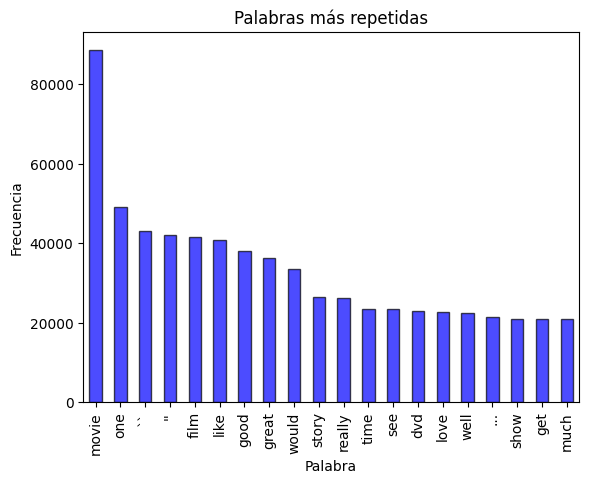

Palabras más repetidas y su frecuencia:
movie     88650
one       49036
``        43146
''        41984
film      41473
like      40795
good      38108
great     36412
would     33610
story     26466
really    26170
time      23456
see       23455
dvd       22931
love      22750
well      22543
...       21486
show      21033
get       21001
much      20863
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convierto la columna 'review' en una sola lista de tokens y cuento su frecuencia
all_tokens = [token for sublist in train_data['clean_tokens'] for token in sublist]
token_counts = pd.Series(all_tokens).value_counts()

# Selecciono las 20 palabras más repetidas
top_words = token_counts.head(20)

# Creo el histograma
top_words.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Palabras más repetidas')
plt.show()

# Muestro las palabras más repetidas y su frecuencia
print("Palabras más repetidas y su frecuencia:")
print(top_words)


Como puede apreciarse en el gráfico, hay dos tokens (``,'') que no tiene sentido mantenerlos ya que no son palabras como sí, sino que son símbolos que trás haber hecho la separación en tokens, estos símbolos se han considerado como tokens. Estos tokens creo que no van a aportar ningún valor al modelo, por lo que voy a revisar una lista con los tokens más repetidos para comprobar si existe algún otro token extraño que pueda ser eliminado.

In [ ]:
# Ajustar la configuración de visualización para mostrar más filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Imprimir la serie completa token_counts
print(token_counts.head(500))


movie            88650
one              49036
``               43146
''               41984
film             41473
like             40795
good             38108
great            36412
would            33610
story            26466
really           26170
time             23456
see              23455
dvd              22931
love             22750
well             22543
...              21486
show             21033
get              21001
much             20863
first            20783
series           20279
34               20058
watch            19976
even             19211
movies           18866
season           16999
could            16780
also             16479
best             14977
way              14630
people           14526
think            14131
characters       13610
many             13601
better           13135
two              13046
make             12428
little           12364
know             12254
watching         12120
still            12044
made             12000
character  

Observando la lista de 500 tokens más repetidos es posible apreciar como existen seis tokens que no tiene sentido mantenérlos:
*   ``
*   ''
*   ...
*   --
*   ..
*   ....

Por ello, procedo a su eliminación.










In [ ]:
import pandas as pd
import re


# Defino los símbolos a eliminar
symbols_to_remove = ["``", "''", "...", "--", "..", "..."]

def remove_symbols(tokens):
    clean_tokens = [re.sub('|'.join(map(re.escape, symbols_to_remove)), '', token) for token in tokens]
    clean_tokens = [token.strip() for token in clean_tokens if token.strip()]  # Eliminar espacios en blanco adicionales
    return clean_tokens

# Aplico la función a la columna clean_tokens
train_data['clean_tokens'] = train_data['clean_tokens'].apply(lambda tokens: remove_symbols(tokens))


Compruebo que los símbolos se han eliminado correctamente.

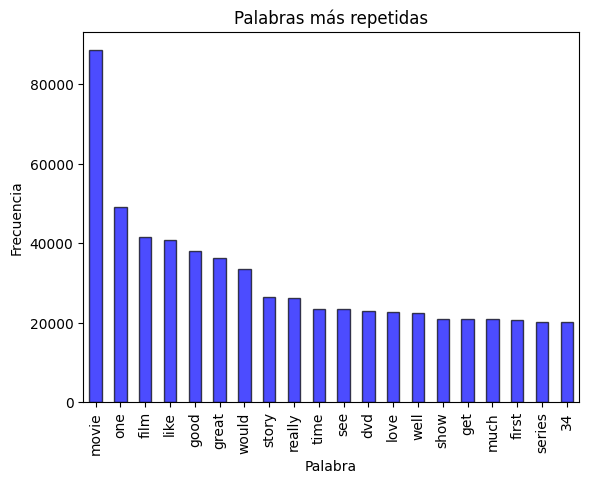

Palabras más repetidas y su frecuencia:
movie     88650
one       49036
film      41473
like      40795
good      38108
great     36412
would     33610
story     26466
really    26170
time      23456
see       23455
dvd       22931
love      22750
well      22543
show      21033
get       21001
much      20863
first     20783
series    20279
34        20058
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convierto la columna 'review' en una sola lista de tokens y cuento su frecuencia
all_tokens = [token for sublist in train_data['clean_tokens'] for token in sublist]
token_counts = pd.Series(all_tokens).value_counts()

# Selecciono las 20 palabras más repetidas
top_words = token_counts.head(20)

# Creo el histograma
top_words.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Palabras más repetidas')
plt.show()

# Muestro las palabras más repetidas y su frecuencia
print("Palabras más repetidas y su frecuencia:")
print(top_words)

Con el fin de asegurarme, cambio la configuración del notebook para poder visualziar las 500 palabras más repetidas.

In [ ]:
# Ajusto la configuración de visualización para mostrar más filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Imprimo la serie completa token_counts
print(token_counts.head(500))


movie            88650
one              49036
film             41473
like             40795
good             38108
great            36412
would            33610
story            26466
really           26170
time             23456
see              23455
dvd              22931
love             22750
well             22543
show             21033
get              21001
much             20863
first            20783
series           20279
34               20058
watch            19976
even             19211
movies           18866
season           16999
could            16780
also             16479
best             14977
way              14630
people           14526
think            14131
characters       13610
many             13601
better           13135
two              13046
make             12428
little           12364
know             12254
watching         12120
still            12044
made             12000
character        11749
never            11741
seen             11208
new        

Seguidamente, procedo a aplicar la lematización a los tokens limpios. Me decanto por esta técnica en vez de por la de stemming porque deseo que las palabras resultantes sean palabras reales y que se tenga en cuante el análisis morfológico. Por medio del stemming a veces se consiguen palabras que no existen como lik en vez de like por lo que creo que es más correcto utilizar la lematización.

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Descargolos recursos necesarios de NLTK
nltk.download('wordnet')

# Inicializo el lematizador
lemmatizer = WordNetLemmatizer()

# Función para lemmatizar los tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for word in tokens:
        # Obtengo la categoría gramatical de la palabra
        pos_tag = nltk.pos_tag([word])[0][1][0].upper()
        # Mapeo la categoría gramatical de NLTK a la de WordNet
        wordnet_pos = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'J': wordnet.ADJ,
            'R': wordnet.ADV
        }.get(pos_tag, wordnet.NOUN)
        lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos).lower().strip()
        lemmatized_tokens.append(lemmatized_word)
    return lemmatized_tokens

# Aplico la función a la columna 'clean_tokens' y almaceno el resultado en una nueva columna 'lemmatized_tokens'
train_data['lemmatized_tokens'] = train_data['clean_tokens'].apply(lemmatize_tokens)

# Compruebo el resultado
print(train_data.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                         review_text  rating_note  \
0  I loathe most American detective dramas. There...          5.0   
1  The storyline was great.  Looking for the last...          3.0   
2  Well, at least the first film was bearable. It...          3.0   
3  Whilst not being near the best of Crosby films...          5.0   
4  Best season so far. The cast has outdone thems...          5.0   

                                       review_tokens  \
0  [I, loathe, most, American, detective, dramas,...   
1  [The, storyline, was, great, ., Looking, for, ...   
2  [Well, ,, at, least, the, first, film, was, be...   
3  [Whilst, not, being, near, the, best, of, Cros...   
4  [Best, season, so, far, ., The, cast, has, out...   

                                        clean_tokens  \
0  [loathe, american, detective, dramas, endings,...   
1  [storyline, great, looking, last, chapter, lov...   
2  [well, least, first, film, bearable, glorious,...   
3  [whilst, near, best, 

Selecciono un review aleatorio y compruebo que se ha aplicado correctamente.

In [ ]:
import random

# Genero un índice aleatorio
random_index = random.randint(0, len(train_data) - 1)

# Obtengo los tokens originales y los tokens lematizados para el índice aleatorio
clean_tokens = train_data.loc[random_index, 'clean_tokens']
lemmatized_tokens = train_data.loc[random_index, 'lemmatized_tokens']

# Compruebo ambas columnas
print("Tokens originales:", clean_tokens)
print("Tokens lematizados:", lemmatized_tokens)



Tokens originales: ['story', 'duke', 'duchess', 'windsor', 'always', 'well', 'known', 'movie', 'brings', 'light', 'strength', 'character', 'prince', 'albert', 'wife', 'deal', 'speech', 'impediment', 'get', 'help', 'needed', 'allow', 'speak', 'english', 'people', 'inspire', 'strength', 'resist', 'bombings', 'london', 'hitler', 'german', 'nazis.wonderful', 'story', 'beautifully', 'acted', 'miss', 'seeing', 'interested', 'anything', 'wwii', 'remember', 'parents', 'current', 'queen', 'elizabeth', 'wish', 'children', 'inherited', 'character', 'grandfather', 'grandmother']
Tokens lematizados: ['story', 'duke', 'duchess', 'windsor', 'always', 'well', 'know', 'movie', 'brings', 'light', 'strength', 'character', 'prince', 'albert', 'wife', 'deal', 'speech', 'impediment', 'get', 'help', 'need', 'allow', 'speak', 'english', 'people', 'inspire', 'strength', 'resist', 'bombing', 'london', 'hitler', 'german', 'nazis.wonderful', 'story', 'beautifully', 'act', 'miss', 'see', 'interested', 'anything', 

Se puede comprobar como la lematización se ha aplicado correctamente. Por ejemplo palabras en plural como tells o means se han transformado en singular y verbo en gerundio como acting se ha transformado en act.

Por otro lado, en todo este proceso de normalización del texto, no he hecho ningún cambio sobre los tokens de tipo numérico. El problema que se está intentando implementar es el de clasificar unas reseñas en función de los comentarios de los usuarios y en mi opinión, creo que los números en el texto pueden tener relevancia semántica y su contexto puede ser importante. Es por eso que he decidido no realizar ningún cambio sobre los números y los he mantenido en formato numérico.



Tras haber finalizado la lemitazación, doy por concluida la normalización de los datos. Como resultado, se obtiene el siguiente dataframe.

In [ ]:
print(train_data.shape)
train_data.head(10)

(99164, 5)


,review_text,rating_note,review_tokens,clean_tokens,lemmatized_tokens
0,I loathe most American detective dramas. There...,5.0,"[I, loathe, most, American, detective, dramas,...","[loathe, american, detective, dramas, endings,...","[loathe, american, detective, drama, ending, a..."
1,The storyline was great. Looking for the last...,3.0,"[The, storyline, was, great, ., Looking, for, ...","[storyline, great, looking, last, chapter, lov...","[storyline, great, look, last, chapter, love, ..."
2,"Well, at least the first film was bearable. It...",3.0,"[Well, ,, at, least, the, first, film, was, be...","[well, least, first, film, bearable, glorious,...","[well, least, first, film, bearable, glorious,..."
3,Whilst not being near the best of Crosby films...,5.0,"[Whilst, not, being, near, the, best, of, Cros...","[whilst, near, best, crosby, films, welcome, s...","[whilst, near, best, crosby, film, welcome, se..."
4,Best season so far. The cast has outdone thems...,5.0,"[Best, season, so, far, ., The, cast, has, out...","[best, season, far, cast, outdone, kathy, bate...","[best, season, far, cast, outdone, kathy, bate..."
5,"A great movie, the best of the three, with a f...",5.0,"[A, great, movie, ,, the, best, of, the, three...","[great, movie, best, three, fantastic, bluray,...","[great, movie, best, three, fantastic, bluray,..."
6,I bought this to go with the others in the Twi...,5.0,"[I, bought, this, to, go, with, the, others, i...","[bought, go, others, twilight, series.i, enjoy...","[bought, go, others, twilight, series.i, enjoy..."
7,"I watched this movie twice, thinking I must ha...",1.0,"[I, watched, this, movie, twice, ,, thinking, ...","[watched, movie, twice, thinking, must, missed...","[watch, movie, twice, think, must, miss, somet..."
8,Great Movie good action.Dwayne Johnson is grea...,5.0,"[Great, Movie, good, action.Dwayne, Johnson, i...","[great, movie, good, action.dwayne, johnson, g...","[great, movie, good, action.dwayne, johnson, g..."
9,Kind of different but decent. Its a good idea ...,4.0,"[Kind, of, different, but, decent, ., Its, a, ...","[kind, different, decent, good, idea, best, wo...","[kind, different, decent, good, idea, best, wo..."


Dado que ejecutar toda esta limpieza lleva su tiempo, voy a guardar el resultado obtenido en un fichero CSV para que pueda acceder a los datos siempre que quiera.

Asimismo, y para finalizar este apartado, destacar que este proceso de limpieza se ha realizado paso a paso para ir comprobando como se iba realizando. Sin embargo, lo interesante es generar un pipeline el cual permita limpiar las reseñas en una misma celda. Este pipeline se creará más adelante una vez haya explorado más en detalle los datos.

In [ ]:
import pandas as pd

# Ruta donde guardar el archivo CSV
ruta_archivo = "/content/drive/MyDrive/Práctica NPL/data_train_clean.csv"

# Guardo el DataFrame en un archivo CSV
train_data.to_csv(ruta_archivo, index=False, sep=';')




#Cardinalidad del vocabulario

Ahora que las reseñas han sido normalizadas, voy a calcular la cardinalidad de todo el vocabulario y de cada una de las reviews. Me parece interesante saber ambas métricas porque creo que es interesante conocer la distribución de los tokens con lo que se trabaja.

Lo primero que voy a hacer es importar de nuevo el archivo. Esto lo hago para tener un punto de control durante la práctica.

In [ ]:
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica NPL/data_train_clean.csv",sep=';')
print(train_data.head())
print("Dimensión conjunto de entrenamiento",train_data.shape)

                                         review_text  rating_note  \
0  I loathe most American detective dramas. There...          5.0   
1  The storyline was great.  Looking for the last...          3.0   
2  Well, at least the first film was bearable. It...          3.0   
3  Whilst not being near the best of Crosby films...          5.0   
4  Best season so far. The cast has outdone thems...          5.0   

                                       review_tokens  \
0  ['I', 'loathe', 'most', 'American', 'detective...   
1  ['The', 'storyline', 'was', 'great', '.', 'Loo...   
2  ['Well', ',', 'at', 'least', 'the', 'first', '...   
3  ['Whilst', 'not', 'being', 'near', 'the', 'bes...   
4  ['Best', 'season', 'so', 'far', '.', 'The', 'c...   

                                        clean_tokens  \
0  ['loathe', 'american', 'detective', 'dramas', ...   
1  ['storyline', 'great', 'looking', 'last', 'cha...   
2  ['well', 'least', 'first', 'film', 'bearable',...   
3  ['whilst', 'near', 'b

In [ ]:
train_data.head()

,review_text,rating_note,review_tokens,clean_tokens,lemmatized_tokens
0,I loathe most American detective dramas. There...,5.0,"['I', 'loathe', 'most', 'American', 'detective...","['loathe', 'american', 'detective', 'dramas', ...","['loathe', 'american', 'detective', 'drama', '..."
1,The storyline was great. Looking for the last...,3.0,"['The', 'storyline', 'was', 'great', '.', 'Loo...","['storyline', 'great', 'looking', 'last', 'cha...","['storyline', 'great', 'look', 'last', 'chapte..."
2,"Well, at least the first film was bearable. It...",3.0,"['Well', ',', 'at', 'least', 'the', 'first', '...","['well', 'least', 'first', 'film', 'bearable',...","['well', 'least', 'first', 'film', 'bearable',..."
3,Whilst not being near the best of Crosby films...,5.0,"['Whilst', 'not', 'being', 'near', 'the', 'bes...","['whilst', 'near', 'best', 'crosby', 'films', ...","['whilst', 'near', 'best', 'crosby', 'film', '..."
4,Best season so far. The cast has outdone thems...,5.0,"['Best', 'season', 'so', 'far', '.', 'The', 'c...","['best', 'season', 'far', 'cast', 'outdone', '...","['best', 'season', 'far', 'cast', 'outdone', '..."


Como he ido almacenando los valores en distintas columnas, los tokens se han almacenado como cadenas en lugar de como listas reales. Como deseo calcular la cardinalidad de las reseñas, convierto las cadenas en listas.

In [ ]:
# Convierto la cadena de la lista en una lista real
train_data['clean_tokens'] = train_data['clean_tokens'].apply(eval)

# Convierto la cadena de la lista lematizada en una lista real
train_data['lemmatized_tokens'] = train_data['lemmatized_tokens'].apply(eval)


Calculo la cardinalidad de todo el vocabulario y la cardinalifad de cada reseña.

In [ ]:
import pandas as pd

# Crear un conjunto vacío para almacenar los tokens únicos
tokens_distintos = set()

# Iterar sobre cada lista de tokens en la columna 'lemmatized_tokens' y agregar los tokens únicos al conjunto
train_data['lemmatized_tokens'].apply(lambda tokens: tokens_distintos.update(set(tokens)))

# Imprimir la cantidad de tokens distintos
print("La cantidad de tokens distintos es:", len(tokens_distintos))

# Creo una nueva columna para conocer el numero de tokens de cada review.
train_data['review_cardinality'] = train_data['lemmatized_tokens'].apply(len)

# Compruebo cuantos tokens hay en total
suma_total = train_data['review_cardinality'].sum()

print("El total de tokens en todo el dataset es:", suma_total)
print(train_data['review_cardinality'].describe())


La cantidad de tokens distintos es: 200874
El total de tokens en todo el dataset es: 5711003
count    99164.000000
mean        57.591495
std         86.936876
min          0.000000
25%         15.000000
50%         27.000000
75%         64.000000
max       3351.000000
Name: review_cardinality, dtype: float64


La cardinalidad de todo el vocabulario es de 200874 tokens. Es importante no confundirse con el parámetro count de 99164 ya que ese valor lo que indica es el total de valores no nulos en la columna review_cardinality. Al haber quitado los valores NaN durante el preprocesamiento, este número coincide con el número de filas del dataframe.

Por otro lado, en total el dataframe contiene 5711003 tokens, de los cuales 5510129 están repetidos. Este dato se sabe porque la resta entre el número total de tokens menos el la cardinalidad del vocabulario, da como resultado ese valor. Es muy curioso ver como prácticamente todos los usuarios utilizan las mismas palabras para expresar su opinión. El 96.5% de los tokens extraidos de las reseñas se repiten por lo que esto demuestra que los seres humanos a la hora de expresar una opinión, solemos utilizar el mismo tipo de lenguaje.

Asimismo, observando los valores obtenidos por la función describe se puede apreciar como de media cada review una vez normalizada tiene 58 tokens. Además, el 75% de los tokens se encuentran por debajo de los 64 tokens, lo cual sirve para hacerse una idea de como se distribuyen los tokens. Sin embargo, es interesante ver como el máximo de tokens para una reseña es de 3551, es decir, un 98% más de la media. Voy a pintar un histograma para observar la distribución de los datos y poder determinar si alguna reseña puede ser considerada como outlier. Para ello, voy a utilizar la columna review_cardinality, en vez de la columna unique_tokens porque quiero que el modelo aprenda a generalizar con reseñas que tengan palabras repetidas ya que es algo que es muy caracterísitico cuando se escribe reseñas.

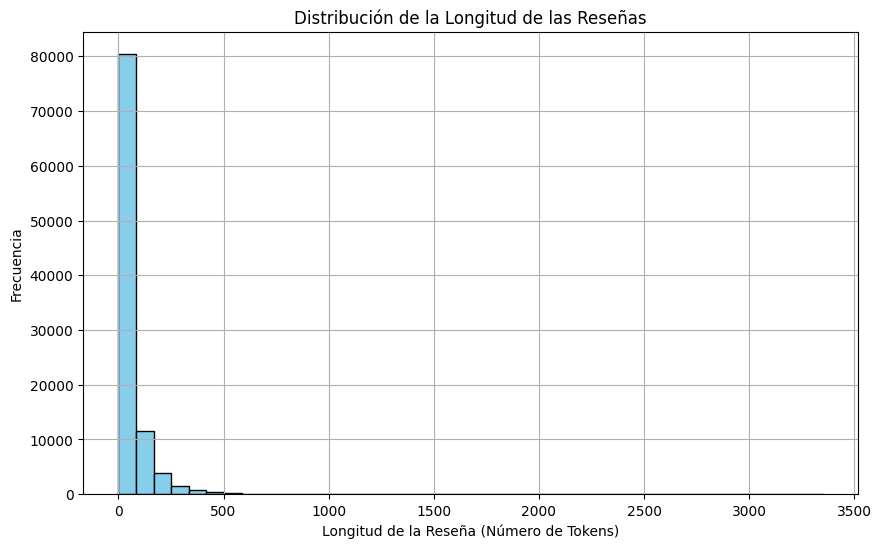

In [ ]:
import matplotlib.pyplot as plt

# Histograma de la columna 'review_cardinality'
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



Como puede apreciarse, la distribución de los token está muy descompensada. Casi todos se agrupan al principio, menos por algunos que se agrupan por encima de una longitud de tokens superior a 500. Voy a comprobar cuantas reseñas poseen más de 500 tokens una vez que se ha aplicado la normalización. Para ello, voy a pintar un gráfico para pintar unicamente las reviews con más de 100 tokens y así poder apreciar con más detalle la distribución.

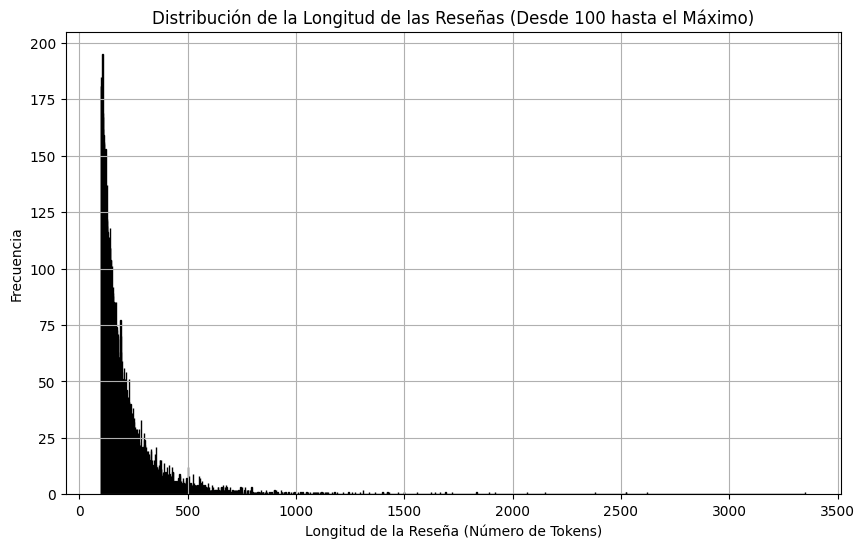

In [ ]:
# Defino el rango para el histograma
max_review_length = train_data['review_cardinality'].max()
rango = range(100, max_review_length + 1)

# Histograma
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=rango, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas (Desde 100 hasta el Máximo)')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



El gráfico obtenido es útil porque permite detectar outliers de una forma sencilla. Se puede apreciar como la longitud de tokens va disminuyendo de forma abrupta y como superado el umbral aproximadamente de 600 tokens, apenas hay reseñas. Esto quiere decir que la mayoría de las reseñas poseen menos de 600 tokens y que a partir de 600 tokens algunas reseñas se podrían considerar como outliers. Voy a comprobar cuantas reseñas poseen más de 600 tokens y que consecuencias en tanto por ciento supondría su eliminación.

In [ ]:
# Filtro el DataFrame para obtener las reseñas con más de 500 tokens
reseñas_mas_de_600 = train_data[train_data['review_cardinality'] > 600]
num_reseñas_mas_de_600 = len(reseñas_mas_de_600)
print("Número de reseñas con más de 600 tokens tras aplicar la normalización:", num_reseñas_mas_de_600)


Número de reseñas con más de 600 tokens tras aplicar la normalización: 285


Únicamente 285 reseñas poseen más de 600 tokens. Estas reseñas suponen un 0,2 por ciento del total del dataset, por lo que eliminarlas no supondría una gran pérdida de información y como beneficio, se tendría un dataset con menos ruido. Es por eso que procedo a eliminar aquellas reseñas que tiene más de 600 tokens y dibujo un histograma para como queda esta distribución una vez eliminada.

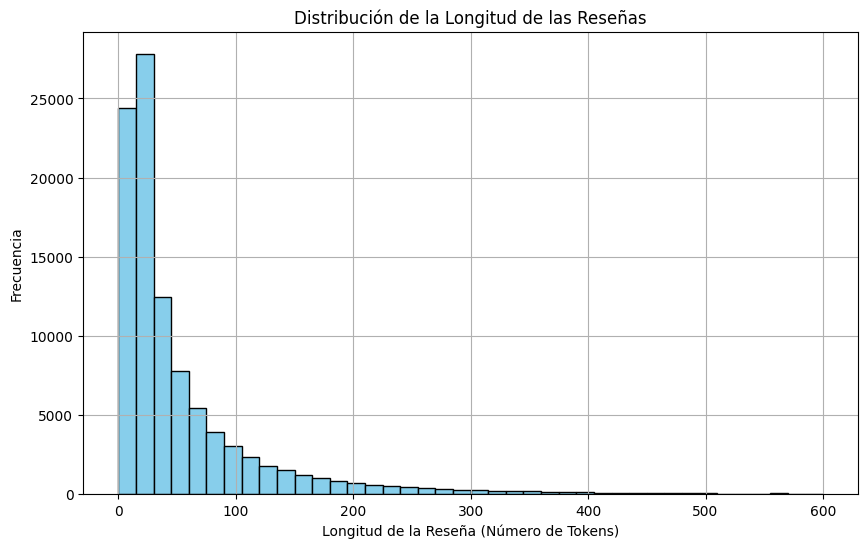

In [ ]:
# Filtro el DataFrame
train_data = train_data[train_data['review_cardinality'] <= 600]

# Histograma de la columna 'review_cardinality'
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



Observando la distribución de datos eliminando aquellas reseñas que poseen más de 600 reseñas, se obtiene un mayor detalle de como se distribuyen los datos. En la última gráfica se puede apreciar como se podría acotar aún más el umbral para considerar una reseña como outlier. Parece que a partir de 400 tokens, apenas hay reviews. Es cierto que si que existen reviews, pero si se observa el gráfico en conjunto, se puede apreciar como elimnar aquellas reviews que tengan más de 400 reviews, no va a suponer una grán pérdida de información. Por ello, voy a calcular cuanto supondría esta pérdida.

In [ ]:
# Filtro el DataFrame para obtener las reseñas con más de 500 tokens
reseñas_mas_de_400 = train_data[train_data['review_cardinality'] > 400]
num_reseñas_mas_de_400 = len(reseñas_mas_de_400)
print("Número de reseñas con más de 400 tokens tras aplicar la normalización:", num_reseñas_mas_de_400)

porcentaje_eliminación = (num_reseñas_mas_de_400*100)/train_data.shape[0]
print("La eliminación de las reseñas con más de 400 tokens supondría la eliminación del:", porcentaje_eliminación,"%" )

Número de reseñas con más de 400 tokens tras aplicar la normalización: 791
La eliminación de las reseñas con más de 400 tokens supondría la eliminación del: 0.7999676372131596 %


Dado que la eliminación supone apenas un 0,8, fijo el umbral en 400. Esto significa que todas las reviews que posean más de 400 tokens, serán eliminadas.

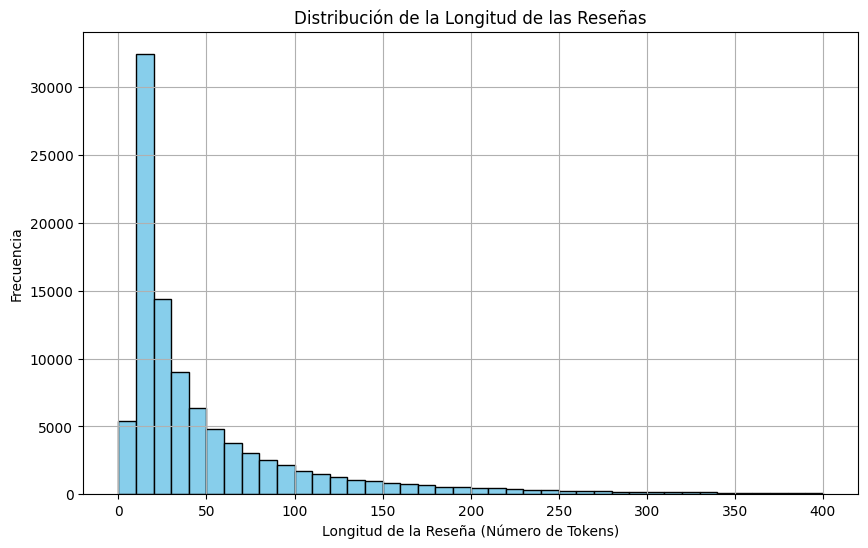

In [ ]:
# Elimino las filas donde review_cardinality sea superior a 400
train_data = train_data[train_data['review_cardinality'] <= 400]

# Histograma de la columna 'review_cardinality'
plt.figure(figsize=(10, 6))
plt.hist(train_data['review_cardinality'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud de la Reseña (Número de Tokens)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


In [ ]:
train_data['review_cardinality'].describe()

count    98088.000000
mean        51.824056
std         61.754631
min          0.000000
25%         15.000000
50%         27.000000
75%         62.000000
max        400.000000
Name: review_cardinality, dtype: float64

Haciendo esta eliminación de outliers,la cardinalidad cambia. Ahora la media de tokens disminuye a 52 por reseña y el tercer cuartil se situa en 62 cuando antes estaba en 64. Obviamente esto es normal ya que he eliminado las reseñas con gran cantidad de tokens. Es un cambio pequeño pero que aportar beneficio al modelo ya que permite la eliminación de ruido de los datos. Este cambio hay que tener en cuenta a la hora de generar el modelo y reportar las métricas.

Por último, genero el comando para comprobar cual es la nueva dimensión del dataset, teniendo en cuenta que se han eliminado 1076 reseñas.

In [ ]:
train_data.shape

(98088, 6)

# Distribución de las reseñas por nota

Aunque durante el proceso de normalización de los datos se han distribuido todos uniformamamente en función de la categoría con menor número de datos, durante el proceso de la cardinalidad se han eliminado 1076 reseñas porque han sido consideradas como outliers. Por ello, aunque el cambio haya sido mínimo, voy a pintar un histrograma para ver que categorías se han visto más afectadas tras esta eliminación.

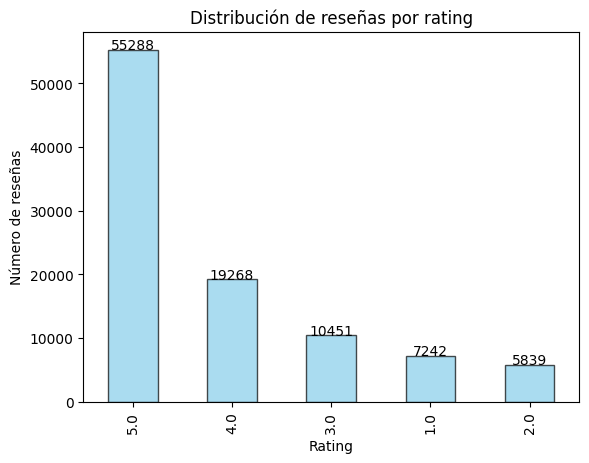

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar el número de reseñas por categoría de rating
rating_counts = train_data['rating_note'].value_counts()

# Crear el histograma
ax = rating_counts.plot(kind='bar', color='skyblue', alpha=0.7, edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Rating')
plt.ylabel('Número de reseñas')
plt.title('Distribución de reseñas por rating')

# Añadir los valores en las barras
for i, count in enumerate(rating_counts):
    ax.text(i, count + 0.1, str(count), ha='center')

# Mostrar el histograma
plt.show()


La siguiente tabla recoge los principales cambios debidos a la eliminación de outliers.

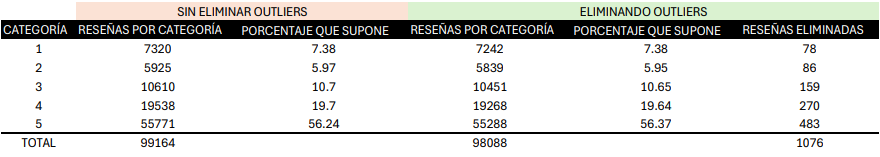




Las principales conclusiones que se pueden estraer son:

*   Todas las categorías se han visto afectadas por la eliminación de outliers. Es curioso ver como los porcentajes de cada categoría respecto al total siguen siendo los mismos. Aunque para cada categoría se haya visto afectada por un distinto número de reseñas eliminadas, las proporciones se siguen manteniendo.

*   Al contrario de lo que podría parecer, las reseñas de categoría 5 eran las más largas y por lo tanto las que más se han eliminado. Podría parecer que en categoría 5, los usuarios indicarán una reseña más corta ya que al ser su satisfacción tan elevada, igual no necesitaban tanta explicación. Sin embargo, esto no es así, ya que 483 han sido eliminadas. También es importante tener en cuenta que previo a la eliminación de outliers, el 56% de reseñas eran de categoría 5 por lo que por probabilidad, era mucho más probable que hubiera una reseña de más de 400 tokens en la categoría 5 que otras.

*   Lo mismo ocurre con el caso extremo de categoría 1. Aunque el corpus posea pocas reseñas de esta categoría, se han eliminado 86 reseñas (8 más que de categoría 2). Esto lo que está indicando que los usuarios cuando no están nada conformes con un producto tienden a escribir reseñas más largas que cuando están un poco más conformes. Esto si se piensa tiene sentido, ya que si se califica un producto con una estrella, lo normal es explicar con detalle el motivo de la nota.

*   Por último, destacar que tras la eliminación de outliers, el dataset ha disminuido en un 1.10%.






#N-grams más frecuentes

Durante el preprocesamiento de los datos, otro detalle que suele ser interesante de consultar es el conocer las palabras más frecuente o n-gramas más frecuentes que componen el corpus ya que eso puede dar una idea acerca de los datos que se está trabajando. En este caso ya se sabe que los datos corresponden a reseñas de películas y televisión escritas por los usuarios en Amazon pero aún así es una buena práctica realizar este análisis.

Además, es cierto aunque durante la normalización se ha estudiado cuales eran las palabras más comunes pero esto se ha hecho unicamente para ver si había algún signo de puntuación que no se había eliminado y debía ser eliminado. Sin embargo no se ha profundizado en el estudio del mismo. Es por eso a continuación se presenta un análisis sobre los n-grams más frecuentes.

Para realizar este análisis lo primero que se ha hecho es definir una función. Dado que el análisis se va a centrar en realizar unigramas, bigramas y trigramas, creo que el modo más eficiente de abordarlos es mediante una función a la cual se le especifique en la entrada el tipo de n-grama que se desea y como resultado genere la lista y el histograma con las palabras más frecuentes.

In [ ]:
import nltk
import matplotlib.pyplot as plt
from nltk import ngrams

# Obtener todas las palabras de todas las reseñas en una lista
all_words = [word for sublist in train_data['lemmatized_tokens'] for word in sublist]

# Crear un objeto Text a partir de la lista de palabras
text = nltk.Text(all_words)

# Función para obtener los n-gramas más frecuentes y mostrar un histograma
def plot_top_ngrams(tokens, n, top=10):
    n_grams = ngrams(tokens, n)
    frequency_dist = nltk.FreqDist(n_grams)
    top_ngrams = frequency_dist.most_common(top)

    # Obtener las frecuencias y los n-gramas
    frequencies = [freq for ngram, freq in top_ngrams]
    ngram_labels = [' '.join(ngram) for ngram, freq in top_ngrams]

    # Crear el histograma
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(top_ngrams)), frequencies, tick_label=ngram_labels)
    plt.xlabel(f'{n}-gramas más frecuentes')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de los {top} {n}-gramas más frecuentes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()




## Unigrama con las 10 palabras más frecuentes

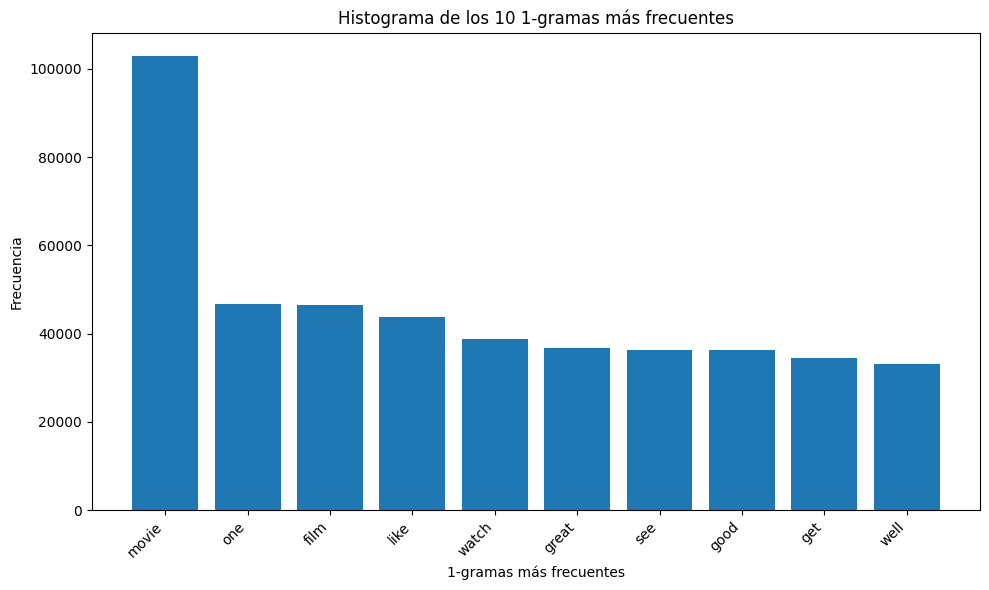

In [ ]:
# Mostrar histograma de los 10 unigramas más frecuentes
plot_top_ngrams(all_words, 1)

Las principales conclusiones que se pueden extraer de este histograma son:

*  **Palabras referentes a películas**: El token más utilizado es movie y el tercero film, las cuales son palabras sinónimas en ingés que expresan película. Obviamente esto tiene sentido ya que los datos con lo que se está trabjando corresponden a reseñas de películas por lo que es normal que los usuarios utilicen estas palabras en sus reseñas.

*   **Verbos referentes a visualizar**: Verbos como watch, see hacen referencia a la acción de ver la película por lo que es normal que estos tokens sean tan comúnes en el dataframe.

*  **Palabras para expresar opinión**: Palabras como like, good, great, well Todas estas palabras tienen en común que hacen referencia a la opinión de una persona sobre algo. En este caso se sabe que son películas por lo que es normal que los usuarios utilicen estas palabras para expresar su opinión.


En definitiva, los tokens que más se repiten en las reseñas tienen sentido con lo que se esperaba ya que todos ellos indican que se está tratando con reseñas referentes a películas. Asimismo, destacar que a priori los tokens son adjetivos son positivos (good, well). Esto refleja claramente el desbalanceo del corpues ya que como recordatotiro el 56% de las reseñas son de categoría 5. Como consecuencia, al haber más proporción de reseñas con buena nota, es normal que los tokens más utilizados sean positivos.


## Bigrama con las 10 palabras más frecuentes

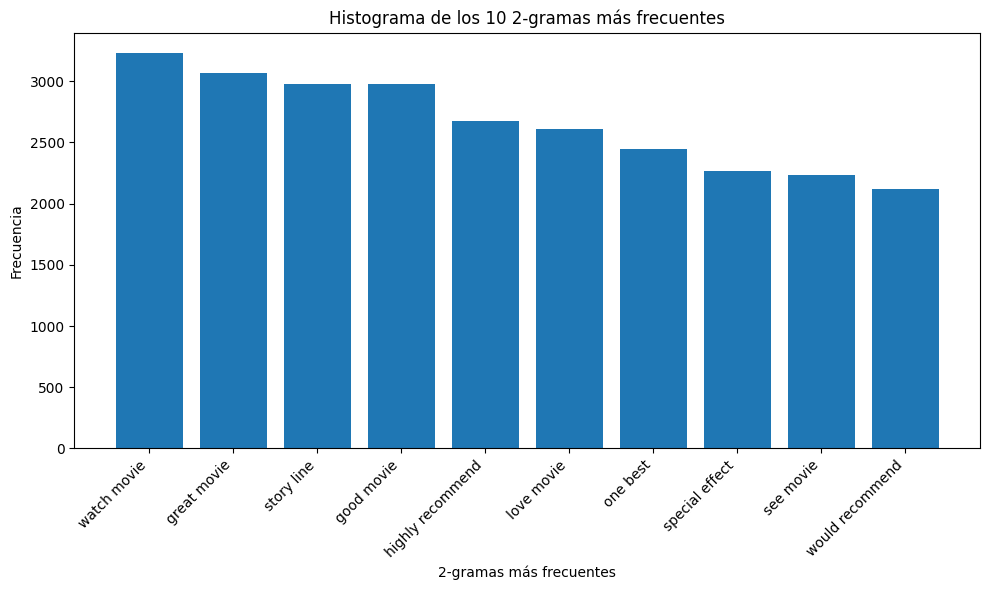

In [ ]:
# Mostrar histograma de los 10 bigramas más frecuentes
plot_top_ngrams(all_words, 2)


El bigrama obtenido es interesante porque permite extraer en este caso conclusiones distintas al apartado anterior:

*   **Contexto de las palabras**: Al realizar el gráfico de bigramas es posible empezar a ver significados que antes no se podría obtener. Por ejemplo, el bigrama good movie, great movie, one best indican lo que se suponía en el apartado anterior y es que la mayoría de las reseñas son positivas. Esta confirmación se obtiene gracias al contexto de las palabras ya que por ejemplo la palabra movie por separado puede ser positivo o negativo, pero en cambio el bigrama good movie no deja lugar a dudas.

*   **Bigrama referente a reseñas de películas**: Asimismo, el bigrama que más se repite es el de watch movie, lo cual era esperado puesto que se tratan de reseñas de películas por lo que es normal que se repita ese bigrama.

*   **Bigramas que expresan opinión**: Por ejemplo, el bigrama highly recommend o el bigrama would recommend están compuestas por palabras que por separado no ofrecen mucha información pero en cambio cuando se combinan con la otra palabra, su contexto cambia el significado. Ambos bigramas están indicando que se está expresando una opinión, lo cual es lo esperado en una reseña.

*  **Bigrama referente a películas**: Me parece curioso y creo que merece la pena destacarlos, los bigramas special effect y story line ya que estos bigramas en sí son conceptos. Efectos especiales es el concepto que está compuesto por dos palabras y esto demuestra lo importante que es el contexto en el lengüaje ya que la unión de una palabra con otra, cambia por completo el sentido de la frase. Es por eso que en NPL es importante captutar este sentido.





## Trigrama con las 10 palabras más frecuentes

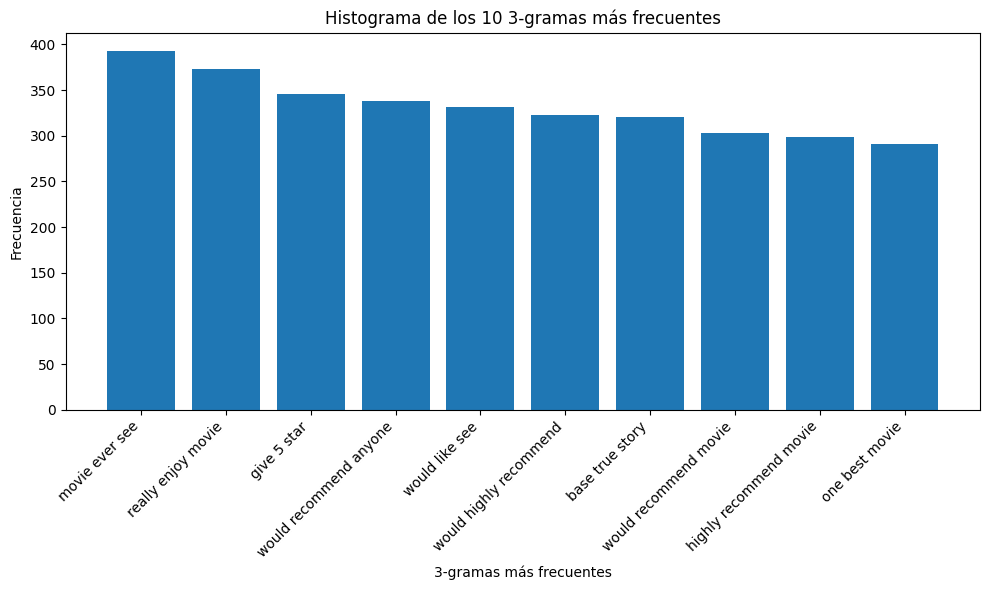

In [ ]:
# Mostrar histograma de los 10 trigramas más frecuentes
plot_top_ngrams(all_words, 3)

Por último, se presenta seguidamente las conclusiones principales de los trigramas:

*   **Refuerzo para expresar opinión**: El ser humano por lo general cuando desea expresar una opinión extrema, tanto positiva como negativa, generalmente tiende a enfatizar su opinión por medio de palabras recurrentes. Esto se puede apreciar en los tres primeros trigramas, en donde se puede visualizar como el usuario está enfatizando lo buena que fue la película. Seguramente, estss trigramas correspondan a reseñas con nota 5 porque por medio de estos trigramas el usuario está expresando su absoluta conformidad. Este ejemplo aunque es muy obvio y muy simple, sirve para mostrar lo importante que es el contexto en el lenguaje y cuan importante es que el modelo que se entrene capte esta contextualidad.

*   **Trigrama para expresar opinión**: Los trigrams ¨would recommend movie¨ o ¨highly recommend movie¨ o ¨would recommend anyone¨ sirven para que se pueda confirmar que se está trabajando con reseñas positivas ya que en ambos casos el usuario está animando al lector a ver la película. Aunque es cierto que en ambos casos, con las dos primeras palabras ya se hubiera identificado que se estaban trabajando con reseñas, está bien poseer más contexto para poder confirmarlo.

*   **Distribución de los datos**: Observando los trigramas se puede ver como reflejan más o menos la distribución desigual de los datos ya que de diez trigramas, nueve son positivos. Seguramente, si se hubiera realizado un balanceo de los datos durante el preprocesamiento, el resultado sería diferente y seguramente se podría observar algún trigrama negativo.



A modo de conclusión para este apartado, en mi opinión creo que a la hora de trabjar con problemas de NLP, el poder conocer los unigramas, bigramas o trigramas puede ser interesante para hacerse una idea de los datos con los que se está trabajando. En este caso ya se sabía con los datos que se estaba trabajando, pero aún así, nos n-gramas pueden servir para confirmar ideas que se puede tener sobre los datos como puede ser su distribución. Es por eso que es interesante realizarlos siempre.

#Nube de palabras

Otra característica que puede ser interesante de conocer cuando se realiza el preprocesamiento es conocer la nube de palabras. En sí, la nube de palabras ofrece la misma información del gráfico unigrama anterior pero con la diferencia de que es más intuitivo. Esto puede ser útil para análisis de negocio o marketing ya que de un simple vistazo, se puede extraer información relevante. Las nubes de palabras funcionan del siguiente modo: las palabras que aparecen en grande son aquellas que aparecen más repetida en el corpus. Es por eso que en este caso las palabras más grandes van a ser aquellas que aparezcan en el diagrama unigrama.

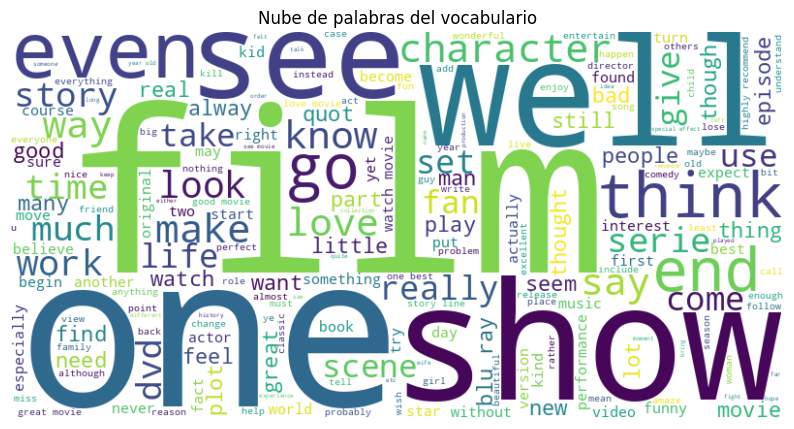

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Obtener todas las palabras de todas las reseñas en una lista
all_words = [word for sublist in train_data['lemmatized_tokens'] for word in sublist]

# Unir todas las palabras en un solo texto
text = ' '.join(all_words)

# Crear una WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Visualizar la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras del vocabulario')
plt.show()


Como se puede apreciar, las palabras coinciden con lo esperado y con un simple vistazo es posible extraer la conclusión de que los datos con los que se está trabajando está referido a películas y reseñas.

Previo a proceder a generar los embeddings, compruebo el tamaño del dataset hasta este momento y guardo los datos en un fichero como punto de control.

In [ ]:
train_data.head()

,review_text,rating_note,review_tokens,clean_tokens,lemmatized_tokens,review_cardinality
0,I loathe most American detective dramas. There...,5.0,"['I', 'loathe', 'most', 'American', 'detective...","[loathe, american, detective, dramas, endings,...","[loathe, american, detective, drama, ending, a...",133
1,The storyline was great. Looking for the last...,3.0,"['The', 'storyline', 'was', 'great', '.', 'Loo...","[storyline, great, looking, last, chapter, lov...","[storyline, great, look, last, chapter, love, ...",68
2,"Well, at least the first film was bearable. It...",3.0,"['Well', ',', 'at', 'least', 'the', 'first', '...","[well, least, first, film, bearable, glorious,...","[well, least, first, film, bearable, glorious,...",24
3,Whilst not being near the best of Crosby films...,5.0,"['Whilst', 'not', 'being', 'near', 'the', 'bes...","[whilst, near, best, crosby, films, welcome, s...","[whilst, near, best, crosby, film, welcome, se...",29
4,Best season so far. The cast has outdone thems...,5.0,"['Best', 'season', 'so', 'far', '.', 'The', 'c...","[best, season, far, cast, outdone, kathy, bate...","[best, season, far, cast, outdone, kathy, bate...",12


In [ ]:
print(train_data.shape)

(98088, 6)


In [ ]:
# Guardo los conjuntos de datos en archivos CSV
train_data.to_csv("/content/drive/MyDrive/Práctica NPL/data_train_embeddings.csv", index=False)

#Embeddings

Lo primero que hago es importar el fichero que había generado como punto de control.

In [ ]:
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Práctica NPL/data_train_embeddings.csv")
print(train_data.head())
print("Dimensión conjunto de entrenamiento",train_data.shape)

# Convertir la cadena de la lista en una lista real
train_data['clean_tokens'] = train_data['clean_tokens'].apply(eval)

# Convertir la cadena de la lista lematizada en una lista real
train_data['lemmatized_tokens'] = train_data['lemmatized_tokens'].apply(eval)

                                         review_text  rating_note  \
0  I loathe most American detective dramas. There...          5.0   
1  The storyline was great.  Looking for the last...          3.0   
2  Well, at least the first film was bearable. It...          3.0   
3  Whilst not being near the best of Crosby films...          5.0   
4  Best season so far. The cast has outdone thems...          5.0   

                                       review_tokens  \
0  ['I', 'loathe', 'most', 'American', 'detective...   
1  ['The', 'storyline', 'was', 'great', '.', 'Loo...   
2  ['Well', ',', 'at', 'least', 'the', 'first', '...   
3  ['Whilst', 'not', 'being', 'near', 'the', 'bes...   
4  ['Best', 'season', 'so', 'far', '.', 'The', 'c...   

                                        clean_tokens  \
0  ['loathe', 'american', 'detective', 'dramas', ...   
1  ['storyline', 'great', 'looking', 'last', 'cha...   
2  ['well', 'least', 'first', 'film', 'bearable',...   
3  ['whilst', 'near', 'b

En el enunciado de la práctica se solicita visualizar en dos dimensiones algunos word embeddings calculados con Word2Vec. Un word embedding es una representación vectorial de una palabra y lo que permite es encontrar las palabras similiares en base a una dada. Un detalle que es importante tener en cuenta es que para encontrar una palabra similar a una dada, el modelo debe haber sido entrenado con esas palabras. Es decir, el modelo no va a generar una palabra que no ha visto nunca que sea parecida a la dada. El modelo encontrará la palabras o palabras similares que haya visto a una dada en base al vocabulario con el que haya sido entrenado.

Los pasos que sigue el modelo para generar los vectores son los siguientes:

1. Empieza el entrenamiento y el modelo asocia a cada palabra un vector aleatorio de n dimensiones. n es un parámetro a definir.
2. El entrenamiento consiste en ir ajustando los valores de los vectores para que las palabras que son similares sus vectores también lo sean.
3. Para ajustar el vector, el modelo toma una palabra objetivo y utiliza su vector de palabra para predecir las palabras del contexto (el número de palabras de contexto se especifica como parámetro). Luego, calcula el error entre las predicciones y las palabras reales del contexto. Este error se utiliza para ajustar los parámetros del modelo, específicamente los vectores de palabra, de modo que las predicciones del modelo se acerquen más a las palabras reales del contexto.
4. Una vez que se ha ajustado el vector de la palabra objetivo, el modelo procede a ajustar los vectores de las palabras del contexto. Para cada palabra del contexto, el modelo lee la palabra objetivo y trata de predecirla. Este proceso se repite para todas las palabras del contexto, y los errores se utilizan para ajustar los vectores de las palabras del contexto.

Por ello, lo primero que se debe hacer es generar el modelo y entrenarlo.

In [ ]:
import os
from gensim.models import Word2Vec


# Obtener el número de núcleos de CPU disponibles
cores = os.cpu_count()

# Configuración del modelo Word2Vec
w2v_model = Word2Vec(min_count=20, #solamente consideraré palabra como valida en el entrenamiento aquella que aparezca más de 20 veces
                     window=2, #la ventana de contexto es de 2 por cada lado por lo que cada palabra objetivo tendrá 4 palabras de contexto.
                     vector_size=100, #cada palabra será representada por un vector de 100 dimensiones. dado que el dataset es grande, prefiero generar un vector ¨pequeño¨ para cada palabra.
                     sample=6e-5,
                     alpha=0.03, #tasa de aprendizaje incial
                     min_alpha=0.0007,#tasa de aprendizaje mínima
                     negative=20,#especifico como veinte las palabras de muestreo. Esto quiere decir que aparte del contexto, el modelo intentará predecir 20 palabras como si estuvieran dentro de la ventana de contexto, cuando en realidad no lo están.
                     workers=cores-1,
                     sg=1) #especifico que quiero utilizar Skip-Gram. Esto quiere decir que en base a una palabra, el modelo intentará predecir el contexto.


#Constuyo el vocabulario con todas las tokens del dataframe
from time import time

t = time()
sentences = train_data['lemmatized_tokens'].tolist()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))


#Entreno el modelo con las palabras del vocabulario
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Tiempo para entrenar el modelo: {} mins'.format(round((time() - t) / 60, 2)))


Tiempo para construir el vocabulario: 0.03 mins
Tiempo para entrenar el modelo: 21.31 mins


Ahora procedo a generar los vectores para cada token de la reseña. Para ello los pasos que voy a seguir son:

1. Reviso las longitudes de las reseñas y decido quedarme con 62 palabras de cada una. 62 es el valor del tercer cuartil y me parece interesante porque creo que va a permitir al modelo capturar bien el contexto de las palabras sin introducir mucho ruido (la media de tokens por reseña es de 52). Por eso creo que es un buen valor.

2. A continuación, para esas 62 palabras de la reseñas, generamos el vector correspondiente a cada palabra. Si la reseña posee menos tokens que el tamaño del tercer quartil, se incluyen vectoes de cero. Los vectores de cada palabra de reseña se agrupan en una matriz.
3. Escalo los vectores para mejorar el rendimiento.
4. Como resultado, se obtiene un tensor en donde cada reseña está representada por una matriz de 62x100. (62 tokens y 100 dimensiones para cada palabra)


Asimismo, dado que poseo 98088 reseñas, voy a generar los vectores en batches y luego uniré cada batch en un tensor que englobe a todos. Este tensor lo guardaré como punto de control.

In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import numpy as np

# Obtengo el tercer cuartil de las longitudes de las reseñas
third_quartile = train_data['review_cardinality'].quantile(0.75)

# Ajusto la longitud de cada vector de reseña con el tercer cuartil
max_length = int(third_quartile)
batch_size = 10000

# Generador para generar los vectores de reseña en lotes
def generate_review_vectors(model, reviews, max_length, batch_size):
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_vectors = []
        for tokens in batch_reviews:
            embeddings = [model.wv[token] for token in tokens if token in model.wv]
            if len(embeddings) < max_length:
                embeddings.extend([np.zeros(model.vector_size)] * (max_length - len(embeddings)))
            elif len(embeddings) > max_length:
                embeddings = embeddings[:max_length]
            batch_vectors.append(embeddings)
        yield np.array(batch_vectors)

# Uso la función para generar los vectores de reseña en batches
review_vectors_generator = generate_review_vectors(w2v_model, train_data['lemmatized_tokens'], max_length, batch_size)

# Lista para almacenar los vectores
all_processed_vectors = []

# Escalo los vectores y los agrego a la lista
for batch_index, batch_vectors in enumerate(review_vectors_generator):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(batch_vectors.reshape(-1, batch_vectors.shape[-1])).reshape(batch_vectors.shape)
    all_processed_vectors.append(vectors_scaled)

# Concateno todos los vectores en un solo tensor
combined_vectors = np.concatenate(all_processed_vectors, axis=0)
print("Forma del tensor resultante:", combined_vectors.shape)




Forma del tensor resultante: (98088, 62, 100)


A continuación voy a reducir la dimensionalidad de los vectores a 2 para poder pintarlos. Para ello voy a utilizar PCA.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualizar_word_embeddings(word, w2v_model, topn=10):
    # Obtengo las palabras más similares a la palabra proporcionada
    similar_words = [similar_word[0] for similar_word in w2v_model.wv.most_similar(word, topn=topn)]

    # Obtengo los vectores de palabra para la palabra proporcionada y sus palabras similares
    vectors = [w2v_model.wv[word]]
    vectors.extend([w2v_model.wv[similar_word] for similar_word in similar_words])

    # Reduzco la dimensionalidad de los vectores a dos dimensiones utilizando PCA
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    # Graficar los vectores en un plano
    plt.figure(figsize=(10, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], marker='o', color='b')

    # Etiqueto cada punto con el nombre de la palabra correspondiente
    plt.annotate(word, xy=(vectors_2d[0, 0], vectors_2d[0, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    for i, similar_word in enumerate(similar_words):
        plt.annotate(similar_word, xy=(vectors_2d[i+1, 0], vectors_2d[i+1, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.title(f'Visualización en 2 dimensiones de los embeddings de la palabra "{word}" y sus {topn} palabras similares')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True)
    plt.show()


En el enunciado se solicita elegir cuatro o cinco palabras para ver sus palabras similares. Por ello, las palabras que se van a dibujar son aquellas más frecuentes, es decir, los unigramas. Voy a dibujar en grande los cinco primeros unigramas y más adelante realizaré un gráfico en donde se visualizará los gráficos para los 10 unigramas más frecuentes.

Comienzo con el primer unigrama: movie.

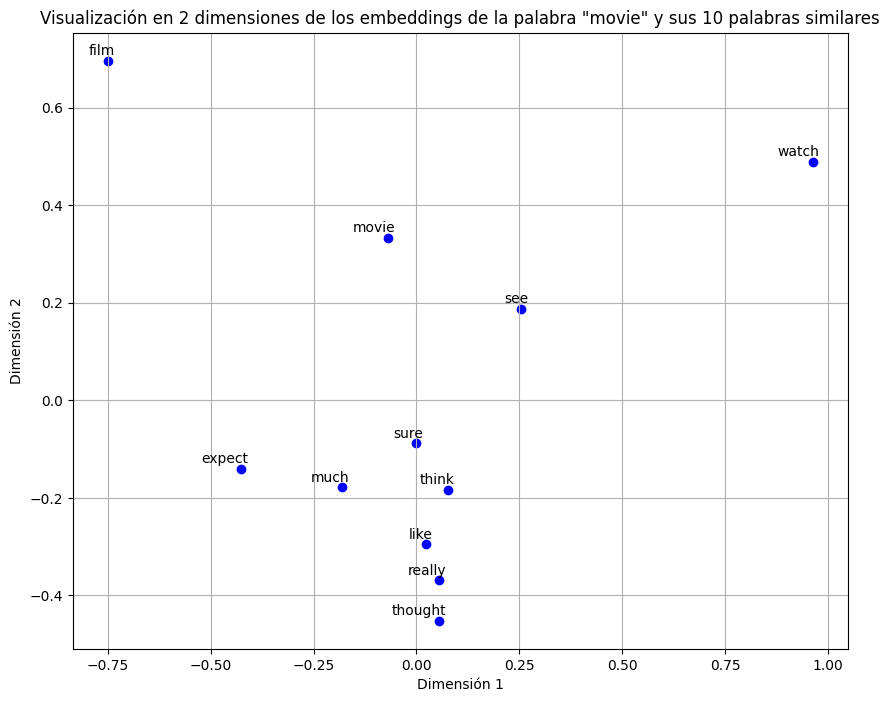

In [ ]:
# Función con la palabra movie
word_to_visualize = 'movie'
visualizar_word_embeddings(word_to_visualize, w2v_model, topn=10)


De este primer unigrama es posible apreciar como las palabras relacionadas con película son o bien sinónimos de la palabra como puede ser film o bien verbos relacionados con ver como puede ser watch o see o bien palabras relacionadas con expresar la opinión. Es importante tener en cuenta que las palabras que se observan en este gráfico están en el vocabulario con el que ha sido entrenado el modelo, es decir, el modelo no se ha inventado estas palabras sin motivo, sino que el motivo por el que las ha representado es porque el modelo ha ajustado cada vector de cada palabra y una vez ajustados, sus vectores con el vector de la película movie son muy parecidos.

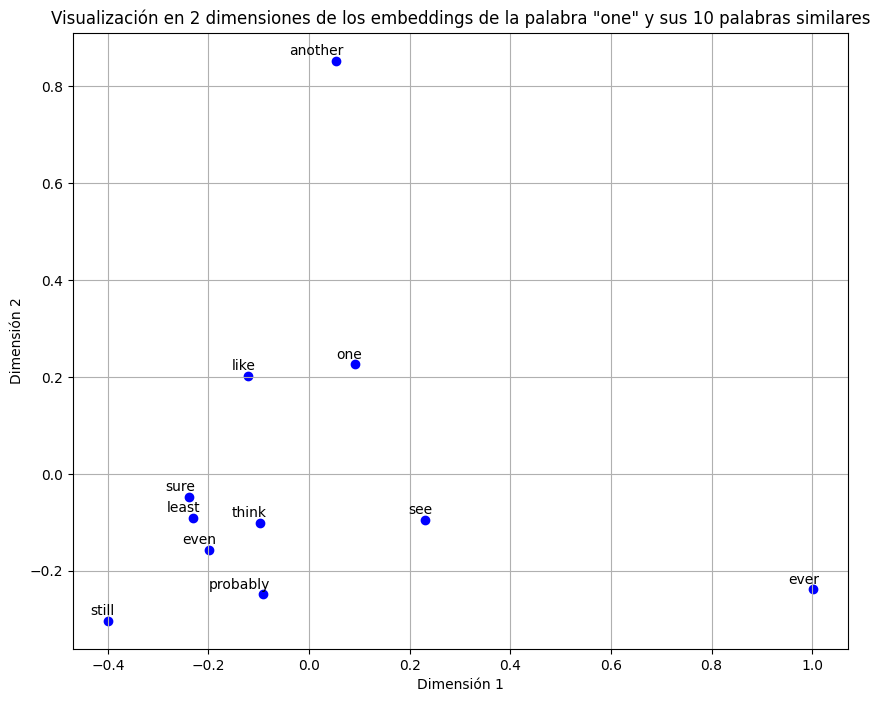

In [ ]:
# Función con la palabra one
word_to_visualize = 'one'
visualizar_word_embeddings(word_to_visualize, w2v_model, topn=10)

Por su parte, el token one tiene como palabras similares adverbios o adjetivos que se utilizan para enfatizar una opinión como puede ser probably, like... Como puede apreciarse, en este caso no aparece las palabras movie o film ya que no tiene sentido que sean parecidas a la palabra one. Desde mi punto de vista, la palabra one es muy ambigüa ya que en función del contexto puede significar una cosa u otra. Sin embargo como el modelo ha sido entrenado con Skip-Gram, ha capturado el contexto de la palabra y por ello gracias a este gráfico se puede ver como la palabra one seguramente se haya utilizado en las reseñas para enfatizar una opinión. Esto se sabe porque sus palabras similares también tienen este propósito.

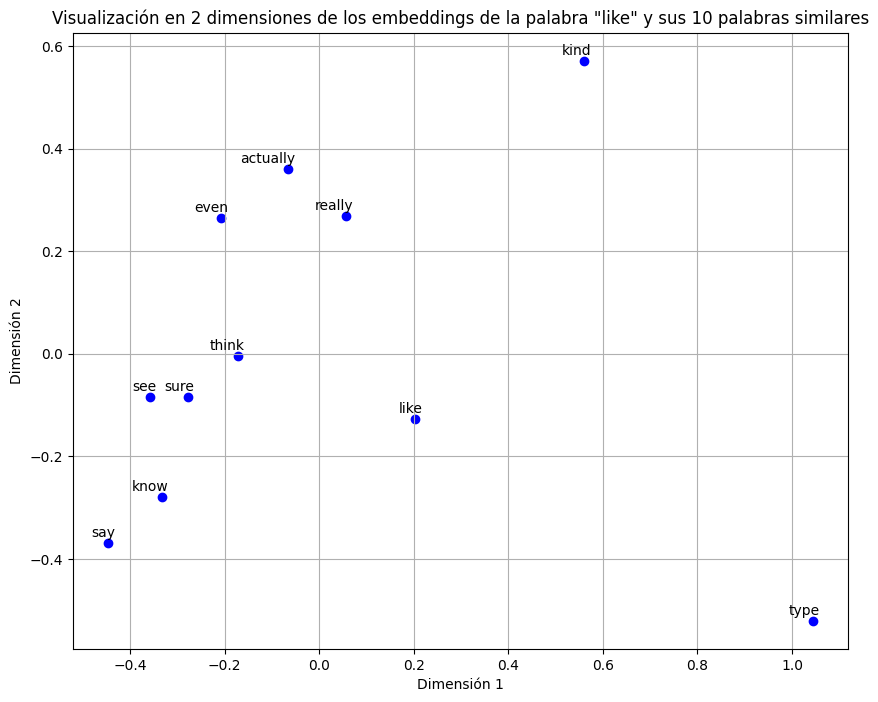

In [ ]:
# Función con la palabra like
word_to_visualize = 'like'
visualizar_word_embeddings(word_to_visualize, w2v_model, topn=10)

Por otro lado, para el token like, las palabras similares son verbos que expresan o bien la idea de formar una opinión o de expresarla y también adverbios o adjetivos para enfatizar la opinión. Esto también tiene sentido dado que la palabra like puede ser utilizada para expresar que algo te gusta o bien para expresar el parecido con otra cosa. Es por eso que las palabras que aparecen en el gráfico tienen sentido.

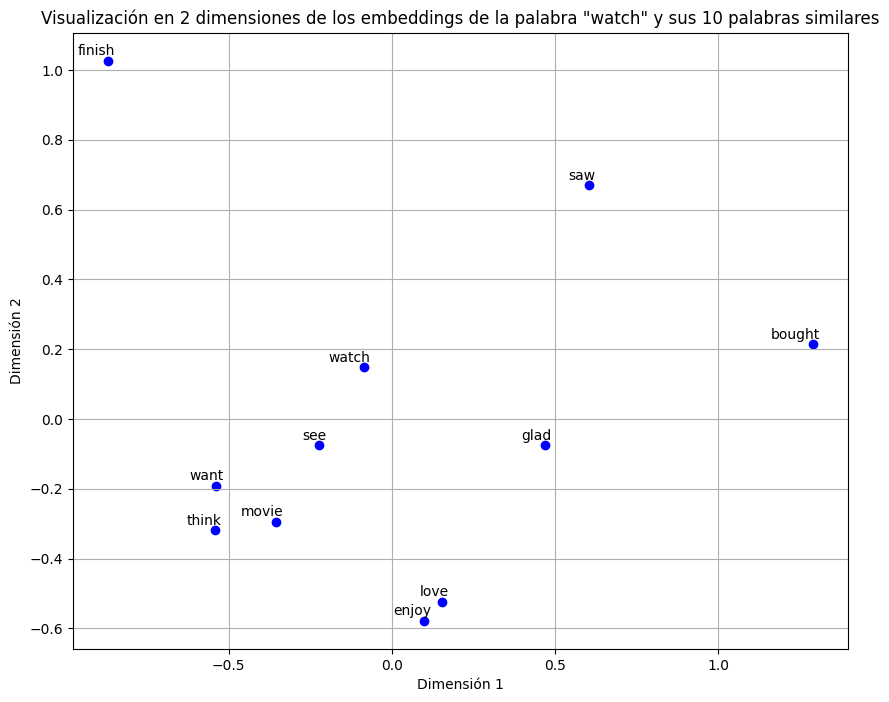

In [ ]:
# Función con la palabra watch
word_to_visualize = 'watch'
visualizar_word_embeddings(word_to_visualize, w2v_model, topn=10)

El token watch es un verbo que expresa la idea de ver una película. Es por eso que existen varias palabras similares a esta como pueden ser see o saw. Estos dos verbos expresan la misma idea con la diferencia de que el segundo es el pasado del primero.
Asimismo, como palabras similares también pareecn otros verbos como want (querer), think (pensar), finish (acabar), bought (participio de comprar), que no son verbos que sean extraños dado que el corpus se trata de reseñas de películas. Es posible hacerse una idea como estos verbos pueden ser utilizados muy frecuentemente en este contexto.
Por último, como se ha comentado durante la práctica, los datos de entrenamiento están desbalanceados y es curioso apreciar como en este gráfico este desbalanceo se aprecia ya que palabras como glad, love son positivas, por lo que si aparecen en este gráfico, lo que está indicando es que hay una clara proporción de reseñas positivas.

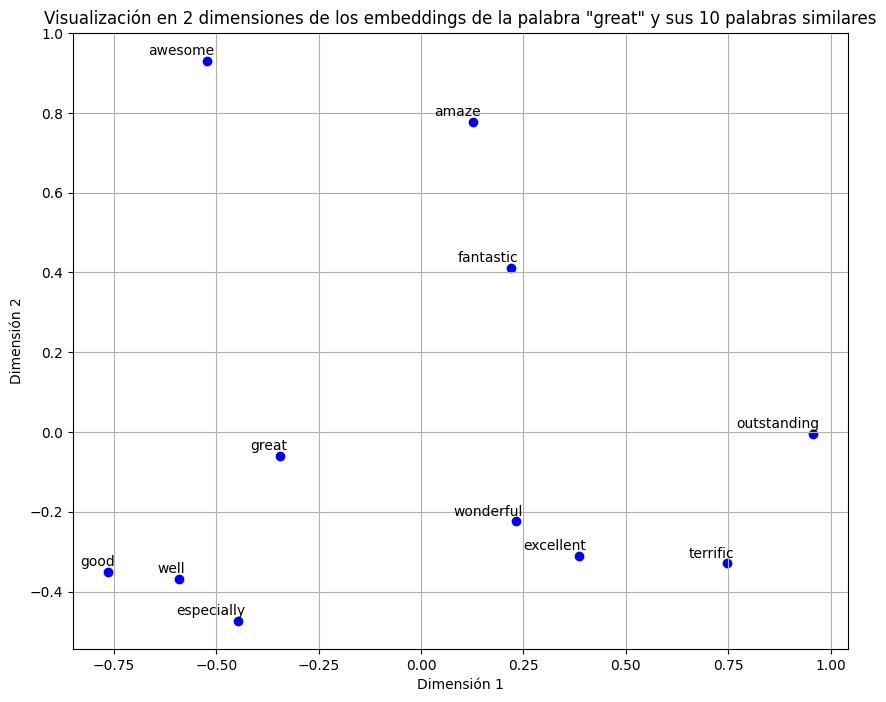

In [ ]:
# Función con la palabra great
word_to_visualize = 'great'
visualizar_word_embeddings(word_to_visualize, w2v_model, topn=10)

Finalmente, el gráfico asociado a la palabra great (es un adjetivo que se podría traducir como excelente) muestra que sus diez palabras más similares son casi todas ellas adjetivos positivos. Posiblemente este gráfico sea el más sencillo de ver ya que es entendible que casi todas las palabras que aparecen en el gráfico se puedan sustituir en el lugar de great en las reseñas y que no cambie el significado de la misma.

Por último, y por curiosidad, dado que ya había definido la función, represento el gráfico para los diez tokens más probables en el vocabulario. Creo que este gráfico puede ser intersante realizarlo porque de un simple vistazo es posible apreciar la relación entre los tokens del vocabulario. Los seis primeros son los mismos que los que se ha comentado previamente (a excepción del gráfico film que he decidido omitirlo).

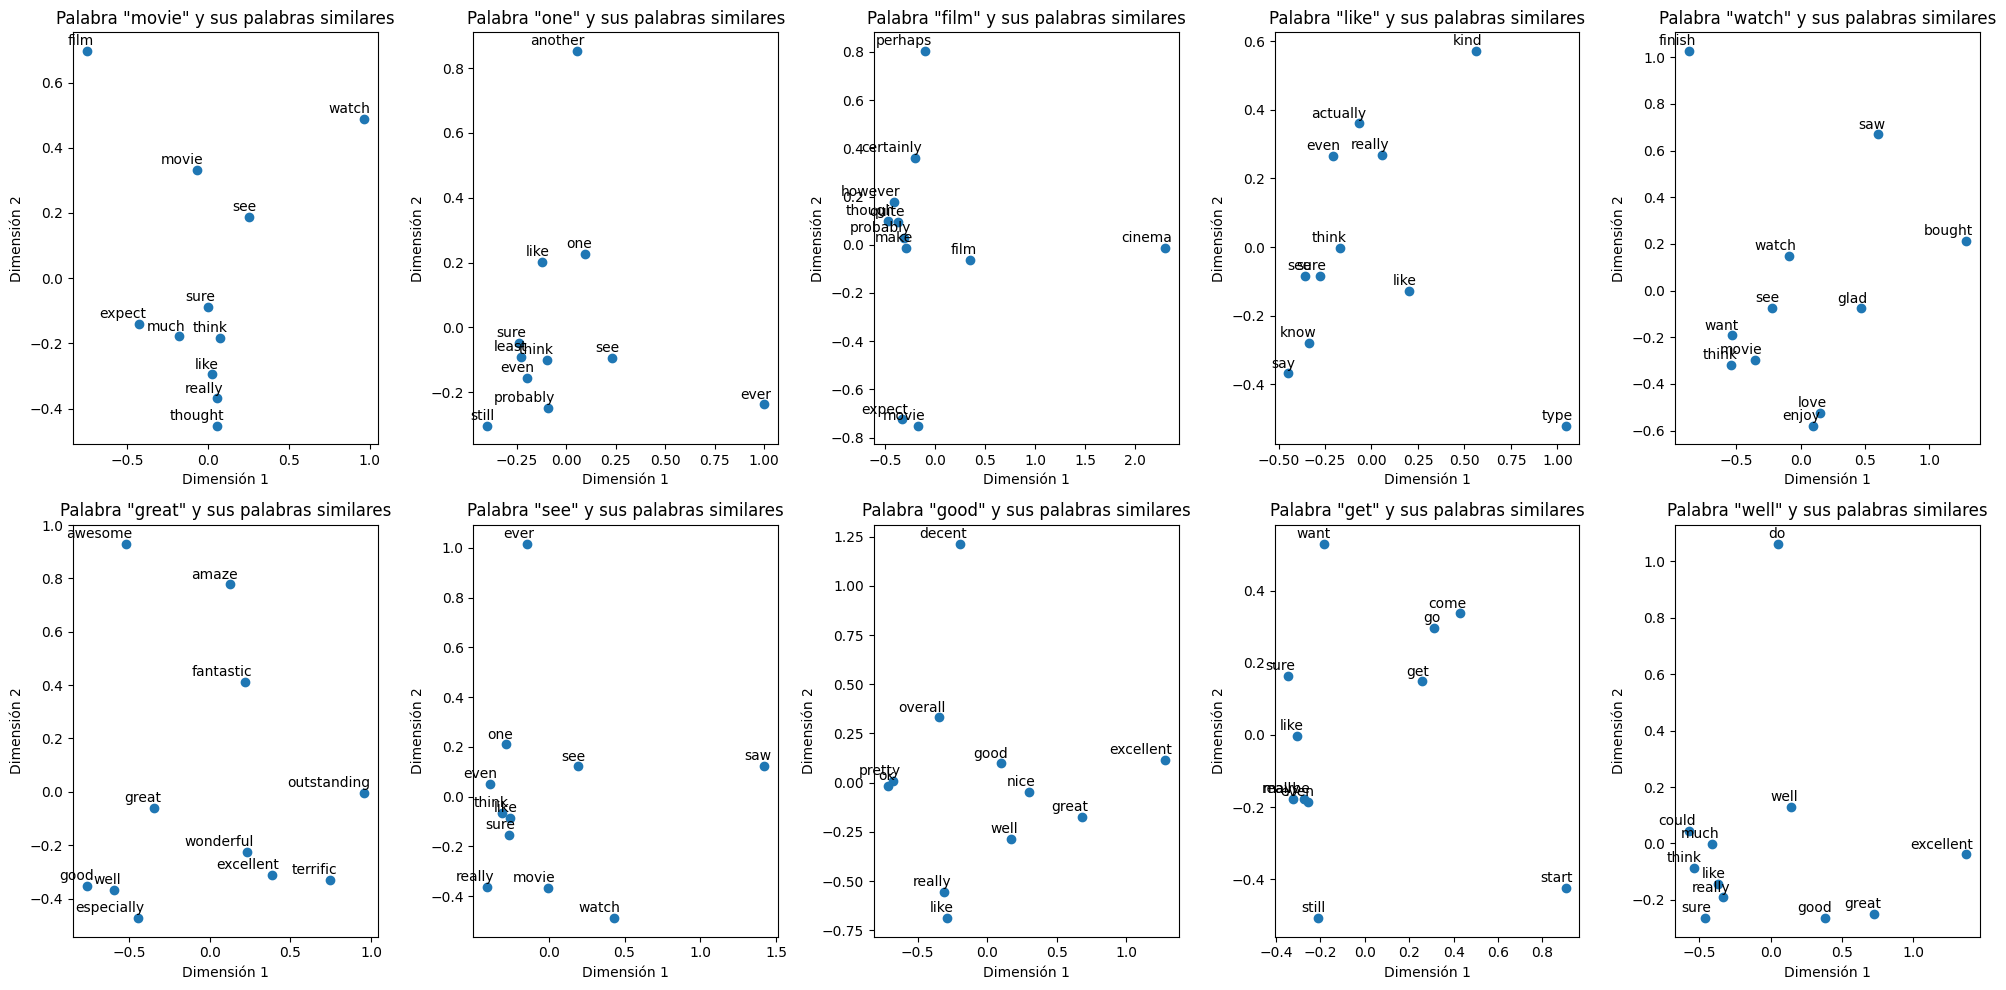

In [ ]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Supongamos que ya tienes cargado tu modelo de word embeddings
# w2v_model = Word2Vec.load("ruta_del_modelo")

def visualizar_word_embeddings(word, w2v_model, topn=10, ax=None):
    # Obtengo las palabras más similares a la palabra proporcionada
    similar_words = [similar_word[0] for similar_word in w2v_model.wv.most_similar(word, topn=topn)]

    # Obtengo los vectores de palabra para la palabra proporcionada y sus palabras similares
    vectors = [w2v_model.wv[word]]
    vectors.extend([w2v_model.wv[similar_word] for similar_word in similar_words])

    # Reduzco la dimensionalidad de los vectores a dos dimensiones utilizando PCA
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    # Graficar los vectores en un plano
    ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], marker='o')

    # Etiqueto cada punto con el nombre de la palabra correspondiente
    ax.annotate(word, xy=(vectors_2d[0, 0], vectors_2d[0, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    for i, similar_word in enumerate(similar_words):
        ax.annotate(similar_word, xy=(vectors_2d[i+1, 0], vectors_2d[i+1, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    ax.set_title(f'Palabra "{word}" y sus palabras similares')
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')

# Lista de palabras
words = ['movie', 'one', 'film', 'like', 'watch', 'great', 'see', 'good', 'get', 'well']

# Crear nuevo gráfico con 2 filas y 5 columnas
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Iterar sobre la lista de palabras y visualizar sus embeddings en cada subplot
for i, word in enumerate(words):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    visualizar_word_embeddings(word, w2v_model, topn=10, ax=ax)

plt.tight_layout()
plt.show()



Analizando un poco los diez gráficos obtenidos se pueden extraer las siguientes conclusiones:

*   Generalmente, suele ocurrir que las palabras más parecidas suelen ser del mismo tipo morfológico que la palabra objetivo. Por ejemplo, si la palabra objetivo es un adjetivo (como good, great), la mayoría de sus palabras parecidas son también adjetivos. Lo mimso pasa si la palabra objetivo es sustantivo, verbo o adverbio.

*   Es cierto que como ya se sabe previamente con que datos se está trabajando, parece obvio que leyendo las palabras de las gráficas se sepa que los datos son reseñas de películas. Sin embargo, creo que si una persona que no supiera nada del problema leyera estos gráficos también llegaría a la misma conclusión. Por ello, creo que interesante estos gráficos porque permiten hacerse una idea de los datos con los que se trabaja. En mi opinión esto creo que podría ser intersante desde un punto de vista de negocio.

*   Finalmente, creo que es importante tener en cuenta que en total el modelo ha sido entrenado con 98088 tokens. En los gráficos, aquellos tokens que aparecen cerca son los que más se parecen y aquellos que están más alejados, son los que menos se parecen. Sin embargo, aunque pueda parecer que la distancia entre palabras es muy grande, en realidad solamente se están pintando las diez más parecidas. Seguramente si se aumentará el número de palabras parecidas, el contexto cambiaría y como consecuencia, las distancias entre palabras parecería más pequeña. Además, si se observa la escala de los gráficos es posible apreciar como la distancia entre palabras es pequeña.





#Conclusión primer apartado

A modo de conclusión de este primer apartado, creo que es interesante recapitular todos los pasos realizado durante este apartado para no perder el contexto de lo que se está intentando conseguir. Los pasos que se han realizado han sido los siguientes:


1.   En primer lugar, se han descargado los datos de reseñas de películas de Amazon y se ha comprobado su distribución. Su distribución no era equitativa pero se ha decidido trabajar con esta desigualdad por asemejarlo lo máximo posible a un problema del mundo real.
2.   Seguidamente, se ha procedido con la normalización del corpus. Para ello, se han limpiado las reseñas por medio de distintas técnicas (minúsculas, contracciones, lematización...) y como resultado se ha obtenido para cada reseña sus tokens más significativos.
3. A continuación, s ha estudiado la cardinalidad del vocabulario y se ha visto como casi todas las reseñas poseían menos de 400 tokens limpios (solo el 2% tenían más). Por ello, se han elimiando las reseñas con más de 400 tokens limpios ya que se han considerado outliers y esto se ha hecho para eliminar ruido al modelo.
4. Una vez ajustados los tokens por reseñas, se ha estudiado los n-grams del vocabulario y su nube de palabras. Esto se ha hecho para hacerse una idea de los datos con lo que se estaba trabajando.
5. Finalmente, se han realizado los embeddings para cada reseña y apoyándose en ellos y por medio del PCA, se graficado las palabras más similares a una dada en 2D.

Con todo ello, se ha finalizado el preprocesamiento de los datos y ya se podría entrenar a un modelo. Sin embargo, cuando se trabaja con datos, una buena práctica consiste en crear un pipeline que permita realizar este preprocesamiento de una forma sencilla de modo que cualquier reseña pueda ser limpiada facilmente. Por lo tanto, en el siguiente apartado de la práctia, se implementa este pipeline.

